In [1]:
import os
import numpy as np
import nrrd
import json
import matplotlib.pyplot as plt

In [2]:
folder = r"D:\extracteddata\018_018"

In [34]:
dose = np.load(os.path.join(folder,"dose.npy"))
img = np.load(os.path.join(folder,"CT.npy"))
with open(os.path.join(folder,"dose_metadata.json")) as f:
    dose_info = json.load(f)
    f.close()
with open(os.path.join(folder,"CT_metadata.json")) as f:
    im_info = json.load(f)
    f.close()
par_r = np.load(os.path.join(folder,"parotid_r_mask.npy"))
par_l = np.load(os.path.join(folder,"parotid_l_mask.npy"))

In [19]:
def dose_expand(img,dose,im_info,dose_info):
    assert dose_info['pixel_size_mm'] == im_info['pixel_size_mm']
    dose_arr = np.zeros_like(img,dtype=np.float64)
    #find number of pixels difference
    x_diff = dose_info['corner_coord'][0] - im_info['corner_coord'][0]
    x_diff = round(x_diff)
    y_diff = dose_info['corner_coord'][1] - im_info['corner_coord'][1]
    y_diff = round(y_diff)
    z_min = np.squeeze(np.argwhere(np.array(im_info['z_list'],dtype=np.float32) == float(dose_info['z_list'][0])))
    z_max = np.squeeze(np.argwhere(np.array(im_info['z_list'],dtype=np.float32) == float(dose_info['z_list'][-1])))
    dose_arr[z_min:z_max+1,y_diff:y_diff+dose.shape[1],x_diff:x_diff+dose.shape[2]] = dose
    return dose_arr

def mask_com(mask):
    livecoords = np.argwhere(mask)
    if livecoords.size == 0:
        print("Empty mask provided")
        return None
    com = np.sum(livecoords,axis=0) / len(livecoords)
    return com

In [6]:

inspect = 120
newdose = dose_expand(img,dose,im_info,dose_info)

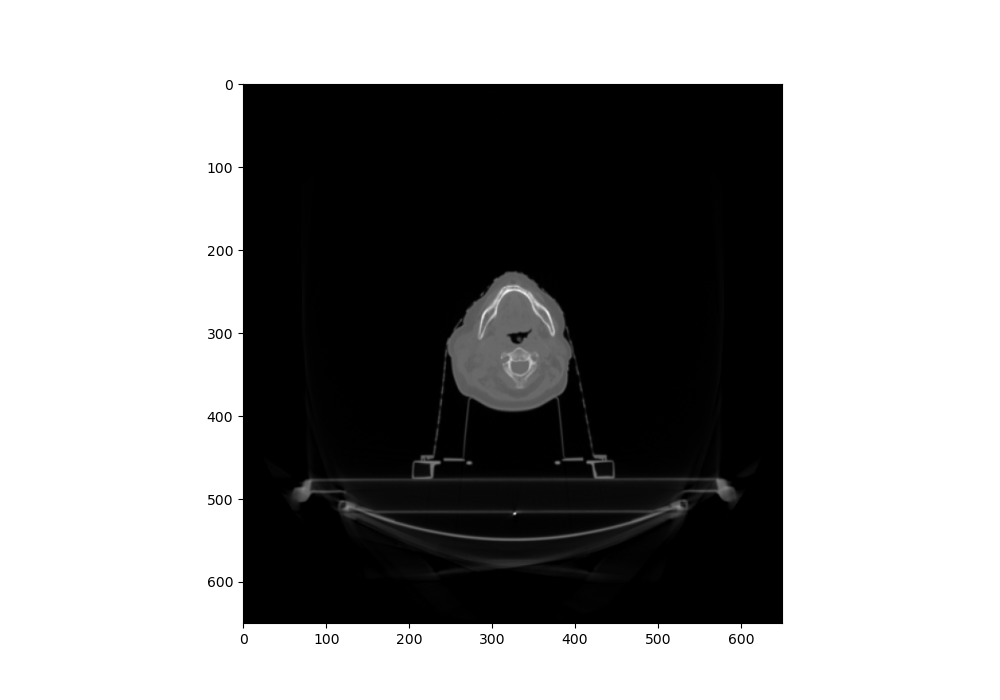

In [57]:
%matplotlib widget
fig,ax = plt.subplots(figsize=(10,7))
ax.imshow(img[inspect,...],cmap='gray')
#ax.imshow(par_l[inspect,...],cmap='bone',alpha=0.25)
#ax.imshow(par_r[inspect,...],cmap='bone',alpha=0.25)
#ax.imshow(newdose[inspect,...],cmap='jet',alpha=0.5)

In [8]:
dose_info['corner_coord']

[-231.0, -104.0]

In [9]:
box_size_r = {}
box_size_l = {}
for patientfolder in os.listdir("D:\\extracteddata"):
    path = os.path.join("D:\\extracteddata",patientfolder)
    if not os.path.isdir(path):
        continue
    par_r = np.load(os.path.join(path,'parotid_r_mask.npy'))
    par_l = np.load(os.path.join(path,'parotid_l_mask.npy'))
    if np.sum(par_r) == 0 or np.sum(par_l) == 0:
        print("{} has no usable masks".format(patientfolder))
        continue
    rbox = np.amax(np.argwhere(par_r),axis=0) - np.amin(np.argwhere(par_r),axis=0)
    lbox = np.amax(np.argwhere(par_l),axis=0) - np.amin(np.argwhere(par_l),axis=0)
    box_size_r[patientfolder] = rbox
    box_size_l[patientfolder] = lbox

018_019 has no usable masks
018_033 has no usable masks


In [17]:
np.amax(np.array(list(box_size_l.values())),axis=0)

array([36, 85, 58], dtype=int64)

In [18]:
np.amax(np.array(list(box_size_r.values())),axis=0)

array([33, 82, 55], dtype=int64)

In [29]:
mask_com(par_l)

array([125.41938326, 237.31414586, 307.11306902])

In [26]:
std_box_shape = (40,90,60)

In [40]:
def prep_inputs(img,dose,par_l,par_r,box_shape=(40,90,60)):
    margin0 = round(box_shape[0] / 2)
    margin1 = round(box_shape[1] / 2)
    margin2 = round(box_shape[2] / 2)
    com_l = np.round(mask_com(par_l)).astype(int)
    com_r = np.round(mask_com(par_r)).astype(int)
    merged_mask = par_l + par_r
    masked_im = img * merged_mask
    masked_dose = dose * merged_mask
    img_l = masked_im[com_l[0]-margin0:com_l[0]+margin0,
                      com_l[1]-margin1:com_l[1]+margin1,
                      com_l[2]-margin2:com_l[2]+margin2]
    img_r = masked_im[com_r[0]-margin0:com_r[0]+margin0,
                      com_r[1]-margin1:com_r[1]+margin1,
                      com_r[2]-margin2:com_r[2]+margin2]
    dose_l = masked_dose[com_l[0]-margin0:com_l[0]+margin0,
                         com_l[1]-margin1:com_l[1]+margin1,
                         com_l[2]-margin2:com_l[2]+margin2]
    dose_r = masked_dose[com_r[0]-margin0:com_r[0]+margin0,
                         com_r[1]-margin1:com_r[1]+margin1,
                         com_r[2]-margin2:com_r[2]+margin2]
    left = np.stack((img_l,dose_l),axis=-1)
    right = np.stack((img_r,dose_r),axis=-1)
    return left, right

In [41]:
test_l, test_r = prep_inputs(img,newdose,par_l,par_r)

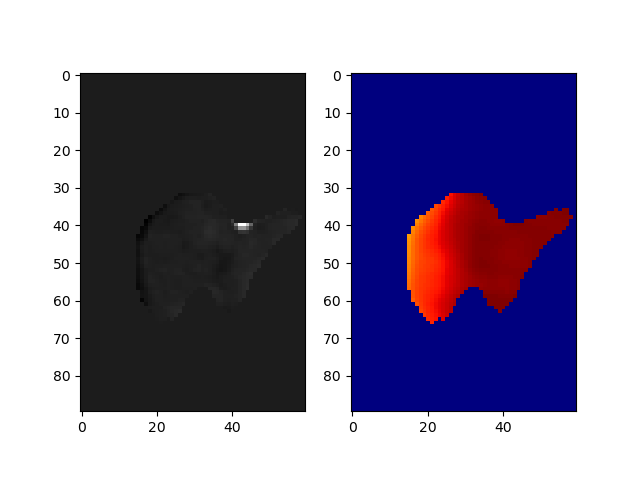

In [58]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(test_r[20,...,0],cmap='gray')
ax[1].imshow(test_r[20,...,1],cmap='jet')

In [59]:
testlist = [1,2,3,4,5]
np.random.shuffle(testlist)

In [60]:
testlist

[3, 1, 4, 5, 2]

In [61]:
np.random.shuffle(testlist)
testlist

[1, 4, 3, 5, 2]

In [63]:
skip = ['018_019','018_033','018_089','018_102','018_117','018_120','018_126','018_128','018_130','018_131']
labels = pd.read_csv(r"D:\extracteddata\labels.csv")

In [64]:
pos = 0
neg = 0
for i,row in labels.iterrows():
    if row['patient'] in skip:
        continue
    if row['xero'] == 1:
        pos += 1
    elif row['xero'] == 0:
        neg += 1
        
print(pos,neg)

30 31
